In [22]:
import numpy as np
import pandas as pd
from os.path import join as oj
import os
import pandas as pd
import sys
import inspect
import datetime
from scipy.stats import percentileofscore
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)
sys.path.append(parentdir + '/modeling')
import load_data
from fit_and_predict import add_preds
from functions import merge_data
from viz import  viz_interactive
import numpy as np
import pandas as pd
from os.path import join as oj
import os
import pandas as pd
import sys
import matplotlib as plt
from scipy.stats import percentileofscore
from sklearn.metrics import mean_absolute_error

# CHANGE THIS
from exponential_modeling import *
from fit_and_predict import *

# Importing sm 
import statsmodels.api as sm

In [574]:
# Random: Understanding c
c = 1
w1 = np.exp(-c*0.5)
w2 = np.exp(-c*0.02)
summ = w1 + w2
w1 = w1/summ
w2 = w2/summ
print(w1,w2)

0.3822521252307511 0.617747874769249


$Y_{t} < X_{t}$ this implies that

$\exp(Y) < \exp(X_{t})$

$frac * N = number of days$, which implies $$

[0.1692194  0.57462026]


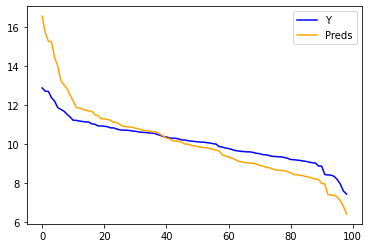

In [102]:
## Toy Example with Exponential
X = np.random.normal(size=100) + 10
X[::-1].sort() # Descending Sort
Y = X[1:]
X = X[:-1]
# X = np.exp(-X)
# plt.plot(X, color="blue")
# plt.plot(Y, color="orange")

# Fit and add a Bias Term
model = sm.GLM(Y, [[x]+[1] for x in X],
           family=sm.families.Poisson())

# model = model.fit()
model = model.fit_regularized()

print(model.params)

preds = model.predict([[x]+[1] for x in X])

plt.plot(Y, color="blue", label="Y")
plt.plot(preds, color="orange", label="Preds")
plt.legend()

Text(0, 0.5, 'Hospitalizations at time t+1')

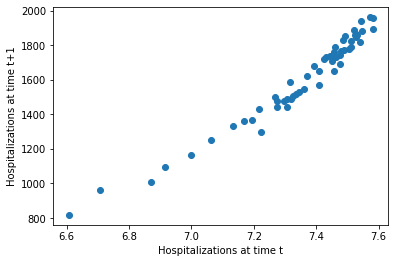

In [123]:
X_LA = df_hos[df_hos["CountyName"] == "Los Angeles"]["hospitalizations"].values
Y_LA = X_LA[1:]
X_LA = X_LA[:-1]

plt.scatter(np.log(X_LA+1), Y_LA)
plt.xlabel("Hospitalizations at time t")
plt.ylabel("Hospitalizations at time t+1")

[-0.00355692  2.48471684]


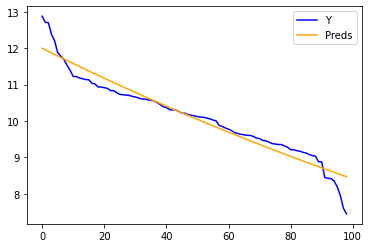

In [121]:
# Fit and add a Bias Term
ts = np.array(range(0, len(Y)), dtype="float")
model = sm.GLM(Y, [[x]+[1] for x in ts],
           family=sm.families.Poisson())

# model = model.fit()
model = model.fit_regularized()

print(model.params)

preds = model.predict([[x]+[1] for x in ts])

plt.plot(Y, color="blue", label="Y")
plt.plot(preds, color="orange", label="Preds")
plt.legend()

In [5]:
# Load in the Data

print('loading data...')
NUM_DAYS_LIST = [1, 2, 3, 4, 5, 6, 7]
df_county = load_data.load_county_level(data_dir=oj(parentdir, 'data'))

#df_county = add_preds(df_county, NUM_DAYS_LIST=NUM_DAYS_LIST,
#                          cached_dir=oj(parentdir, 'data'))

loading data...
loading county-level data...
loaded and merged COVID-19 cases/deaths data successfully


In [2]:
# Parameter Initializations
k = 7
start_day = 15

In [6]:
df_hos = pd.read_csv("../data/CA_hospitalizations.csv")
df_hos = df_hos[["County Name", "Most Recent Date", "COVID-19 Positive Patients"]]
df_hos = df_hos.rename(columns={"County Name": "CountyName", "Most Recent Date": "Date", 
                               "COVID-19 Positive Patients": "hospitalizations"})

In [7]:
# Merge the Data
fips = df_county[df_county["StateName"] == "CA"][["countyFIPS", "CountyName"]]
df_hos = df_hos.merge(fips, on="CountyName", how="left")
df_hos = df_hos.fillna(0)

In [8]:
## Transform data into pipeline-usable format
df_CA = df_hos[["countyFIPS", "CountyName"]].drop_duplicates()
df_CA = df_CA[df_CA["CountyName"] != "Unassigned"]
hospitz = []
for county in df_CA["CountyName"]:
    # Generate the Series
    arr = df_hos[df_hos["CountyName"] == county]["hospitalizations"].values
    hospitz.append(np.concatenate(([0], arr))) # Adding 0 since there seems to be an issue if we don't
#     hospitz.append(np.concatenate(([], arr))) # Adding 0 since there seems to be an issue if we don't

# Append
df_CA["hospitalizations"] = hospitz

In [554]:
df_CA.head().iloc[1].v

array(['06071', 'San Bernardino',
       array([  0.,  95., 126., 118., 138., 146., 148., 146., 132., 136., 156.,
       153., 157., 167., 166., 149., 164., 165., 161., 158., 152., 153.,
       149., 146., 152., 147., 146., 154., 156., 156., 158., 157., 144.,
       154., 156., 155., 167., 153., 142., 145., 144., 152., 148., 133.,
       132., 125., 122., 129., 140., 134., 127., 131., 125., 134., 139.,
       138., 154.])], dtype=object)

In [ ]:
preds = linear_fit(df_CA["hospitalizations"].values, mode="eval_mode")

In [557]:
# Exponential Fit
length = len(df_hos[df_hos["CountyName"] == "Los Angeles"]["hospitalizations"].values)
preds = []
for i in range(4 + k,length):
    hospitz = []
    for county in df_CA["CountyName"]:
        # Generate the Series
        arr = df_hos[df_hos["CountyName"] == county]["hospitalizations"].values[:i]
        hospitz.append(np.concatenate(([0], arr)))
        
#         hospitz.append(np.concatenate(([], arr)))

    # Append
    df_CA["hospitalizations"] = hospitz
    
    
    preds.append(exponential_fit(df_CA["hospitalizations"].values, mode="eval_mode", target_day=np.array([k])))
#     preds.append(linear_fit(df_CA["hospitalizations"].values, mode="eval_mode", target_day=np.array([1])))
    
preds= np.array(preds)[:, :, 0].T
preds = preds[:, 1:] # Drop the first 0s

In [290]:
#### Linear Fit
length = len(df_hos[df_hos["CountyName"] == "Los Angeles"]["hospitalizations"].values)
preds_linear = []
for i in range(4 + k,length):
    hospitz = []
    for county in df_CA["CountyName"]:
        # Generate the Series
        arr = df_hos[df_hos["CountyName"] == county]["hospitalizations"].values[:i]
        hospitz.append(np.concatenate(([0], arr))) 
        # Note: Concatenating 1 to avoid issue with 0's and linear fit

    # Append
    df_CA["hospitalizations"] = hospitz
    
    
#     preds.append(exponential_fit(df_CA["hospitalizations"].values, mode="eval_mode", target_day=np.array([1])))
    res = linear_fit(df_CA["hospitalizations"].values, mode="eval_mode", target_day=np.array([k]))
    preds_linear.append([max(0, x[0]) for x in res])
    
preds_linear= np.array(preds_linear).T
preds_linear = preds_linear[:, 1:] # Drop the first 0s

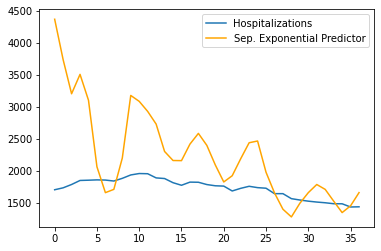

In [291]:
# Let's Plot LA Exponential
LA = df_CA["hospitalizations"][0][4 + k:-1]
preds_LA = preds[0, :]
t = range(max(len(LA), len(preds_LA)))
plt.plot(t, LA, label="Hospitalizations")
plt.plot(t, preds_LA, color="orange", label="Sep. Exponential Predictor")
plt.legend()

In [292]:
# Computing the MAE for LA Exponential
mean_absolute_error(LA, preds_LA)

580.8390913953732

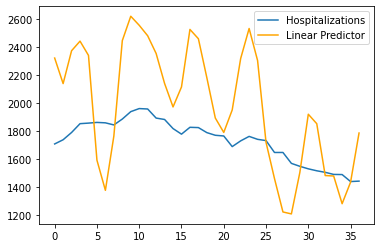

In [293]:
# Let's Plot LA Linear
LA = df_CA["hospitalizations"][0][4 + k:-1]
preds_LA = preds_linear[0, :]
t = range(len(LA))
t_lin = range(len(preds_LA))
plt.plot(t, LA, label="Hospitalizations")
plt.plot(t_lin, preds_LA, color="orange", label="Linear Predictor")
plt.legend()
plt.show()

In [294]:
## Print the MAE Exponential
tmp_df = []
for i in range(0, len(df_CA)):
    tmp_df.append(df_CA["hospitalizations"].values[i][4 + k :-1])

tmp_df = np.array(tmp_df)

print("Raw MAE: %s" % mean_absolute_error(tmp_df, preds))
print("Log MAE: %s" % mean_absolute_error(np.log(tmp_df + 1), np.log(preds + 1)))



Raw MAE: 49.000064580955154
Log MAE: 0.5312408278158054


In [295]:
## Print the MAE Linear
tmp_df = []
for i in range(0, len(df_CA)):
    tmp_df.append(df_CA["hospitalizations"].values[i][4+k: -1])

tmp_df = np.array(tmp_df)

print("Raw MAE: %s" % mean_absolute_error(tmp_df, preds_linear))
print("Log MAE: %s" % mean_absolute_error(np.log(tmp_df + 1), np.log(preds_linear + 1)))



Raw MAE: 17.81696178937558
Log MAE: 0.5633118610381415


In [296]:
# Computing the MAE for LA Linear
mean_absolute_error(LA, preds_LA)

364.74864864864827

# Shared Model

In [10]:
# Does plugging in what we've done above just work?
# preds = fit_and_predict_shared_exponential(df_CA, outcome="hospitalizations", mode="eval_mode")
offset = 2
# Shared Exponential Fit
length = len(df_hos[df_hos["CountyName"] == "Los Angeles"]["hospitalizations"].values)
preds_shared = []
# Start at 3 for 1 day prediction
for i in range(offset + k,length):
    hospitz = []
    for county in df_CA["CountyName"]:
        # Generate the Series
        arr = df_hos[df_hos["CountyName"] == county]["hospitalizations"].values[:i]
        hospitz.append(np.concatenate(([0], arr)))

    # Append
    df_CA["hospitalizations"] = hospitz
    
    # predict_future
    preds_shared.append(fit_and_predict_shared_exponential(df_CA, outcome="hospitalizations",
                                 mode="eval_mode", target_day=np.array([k]), verbose=True))
    
#     preds.append(linear_fit(df_CA["hospitalizations"].values, mode="eval_mode", target_day=np.array([1])))
    
preds_shared= np.array(preds_shared)[:, :, 0].T
preds_shared = preds_shared[:, 1:] # Drop the first 0s 

Feature weights
log(deaths) : 0.532998668197189
bias : 3.461989845943545
Feature weights
log(deaths) : 0.7972839222181415
bias : 3.07896978282319
Feature weights
log(deaths) : 0.9850461975675191
bias : 2.7663665460296563
Feature weights
log(deaths) : 1.115008140718013
bias : 2.531202007894898
Feature weights
log(deaths) : 1.201093026208684
bias : 2.3627692039469594
Feature weights
log(deaths) : 1.2600191676628791
bias : 2.2548844005274677
Feature weights
log(deaths) : 1.300605304974125
bias : 2.1966443071566655
Feature weights
log(deaths) : 1.3315608429353478
bias : 2.14235575359687
Feature weights
log(deaths) : 1.34763443677527
bias : 2.1119246417215023
Feature weights
log(deaths) : 1.3648918275128208
bias : 2.0841199998818603
Feature weights
log(deaths) : 1.378580859401432
bias : 2.0627667634017994
Feature weights
log(deaths) : 1.394154112815669
bias : 2.043660608206072
Feature weights
log(deaths) : 1.4122663115447858
bias : 2.0143361531880073
Feature weights
log(deaths) : 1.42585584

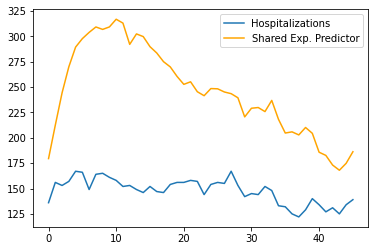

In [97]:
# Let's Plot LA Shared Exponential
LA = df_CA["hospitalizations"][1][offset + k:-1]
preds_LA = preds_shared[1, :] 
t = range(max(len(LA), len(preds_LA)))
plt.plot(t, LA, label="Hospitalizations")
plt.plot(t, preds_LA, color="orange", label="Shared Exp. Predictor")
plt.legend()

In [299]:
## Print the MAE
tmp_df = []
for i in range(0, len(df_CA)):
    tmp_df.append(df_CA["hospitalizations"].values[i][offset + k:-1])

tmp_df = np.array(tmp_df)

print("Raw MAE: %s" % mean_absolute_error(tmp_df, preds_shared))
print("Log MAE: %s" % mean_absolute_error(np.log(tmp_df + 1), np.log(preds_shared + 1)))



Raw MAE: 156.3175148973963
Log MAE: 3.25153094985214


In [300]:
# Computing the MAE for LA
mean_absolute_error(LA, preds_LA)

794.5783394031455

In [301]:
# Just note how this works
tmp = create_shared_simple_dataset(df_CA, outcome="hospitalizations",days_to_subtract=1)
# fit_and_predict_shared_exponential(df_CA, outcome="hospitalizations",
#                                  mode="eval_mode", target_day=np.array([1]))

# Imputing Deaths with CLEP

In [302]:
# Calculate df_CA
# 1/22/2020 to 4/1/2020 is 70 days
shifted_date = 70
cen = 4
df_CA_county = df_county[df_county['StateName'].isin(['CA'])]

# Compute the Imputed Deaths
# lin_impu_future_predictions = []
# exp_impu_future_predictions = []
# shared_impu_exp_future_predictions = []
## Censoring the UCSF_data

LA_data = df_CA["hospitalizations"][0]
# LA_cen = LA_data[cen:]
imputed_deaths = []

## Q: Should beginning of the range be 0 or the start_day?
## Q: Should we include this k? 
## A: I hate time series...
for i in range(1,LA_data.shape[0]-k + 1): 
    df_CA_test = df_CA_county.copy(deep=True)
    # Calculate the Imputed Deaths
    for county in range(len(df_CA_test)):
            # do we need to remove columns and truncate counts??
            # truncate list counts: deaths, cases, neighbor_deaths, neighbor_cases
            for col in ['deaths', 'cases', 'neighbor_deaths', 'neighbor_cases']:
                # adding 1 to predict t
                df_CA_test[col].iloc[county] = df_CA_test[col].iloc[county][:shifted_date + i] 
    
    tmp = fit_and_predict_ensemble(df_CA_test, target_day=np.array([k]))
#     sf_dop = tmp[tmp["CountyName"] == "San Francisco"]

    # Formatting Fix
    imputed_deaths.append(np.array([x[0] for x in tmp["predicted_deaths_ensemble_" + str(k)].values]))
    

imputed_deaths = np.array(imputed_deaths)
imputed_deaths = imputed_deaths.T

In [303]:
preds_shared_imputed = []
for i in range(start_day,LA_data.shape[0]-k + 1): 
    df_shared_CA = df_CA.copy(deep=True)
        
    hospitz = []
    im_arr = []
    for county in df_CA["CountyName"]:
        # Generate the Series
        arr = df_hos[df_hos["CountyName"] == county]["hospitalizations"].values[:i]
        hospitz.append(arr)
        
    for county in range(len(df_CA["CountyName"])):
        # Generate the Series
        im_deaths = imputed_deaths[county, :i]
        im_arr.append(im_deaths)  
        
    assert len(hospitz[0]) == len(im_arr[0]) 

    # Append
    df_shared_CA["hospitalizations"] = hospitz
    df_shared_CA["imputed_deaths"] = im_arr
    
    
    
    # Feature Transforms
    feat_transforms = {}
    feat_transforms["hospitalizations"] = [lambda x: np.log(x+1)]
    feat_transforms["imputed_deaths"] = [lambda x: np.log(x + 1)]
    
    # Auxiliary Time Variables
    aux_vars = ["imputed_deaths"]
    
    # Time Series Default Values
    default_values = defaultdict(lambda: 0) 
    
    # Run the Shared Model
    shared_model = SharedModel(df_shared_CA,mode = "predict_future",
                                                            outcome = "hospitalizations",
                                                            demographic_variables=[],
                                                            auxiliary_time_features=aux_vars,
                                                            target_days=np.array([k]), 
                                                            feat_transforms=feat_transforms,
                                                            time_series_default_values = default_values,
                                                            scale=False)
    
    
    shared_model.create_dataset()
    shared_model.fit_model()
    shared_model.predict()
    
    preds_shared_imputed.append(shared_model.predictions)
    
preds_shared_imputed = np.array(preds_shared_imputed)[:, :, 0].T

/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/base/elastic_net.py:332: RuntimeWarning:

invalid value encountered in double_scalars



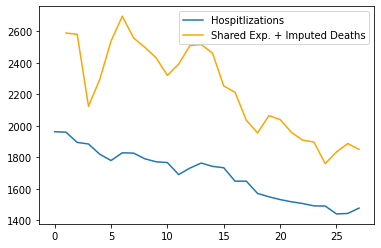

In [304]:
# Let's Plot LA Shared Exponential
LA = df_CA["hospitalizations"][0][start_day + k - 1:]
preds_LA = preds_shared_imputed[0, :] 
t_LA = range(0, len(LA))
t_preds = np.array(range(0, len(preds_LA))) #+ len(t_LA) -len(t_preds) + 2
plt.plot(t_LA, LA, label="Hospitlizations")
plt.plot(t_preds, preds_LA, color="orange", label="Shared Exp. + Imputed Deaths")
plt.legend()

In [305]:
## Print the MAE
tmp_df = []
for i in range(0, len(df_CA)):
    tmp_df.append(df_CA["hospitalizations"].values[i][start_day + k - 1:])

tmp_df = np.array(tmp_df)

print("Raw MAE: %s" % mean_absolute_error(tmp_df, preds_shared_imputed))
print("Log MAE: %s" % mean_absolute_error(np.log(tmp_df + 1), np.log(preds_shared_imputed + 1)))



ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
# Computing the MAE for LA
mean_absolute_error(LA, preds_LA)

# Ensemble Model

In [306]:
exponential = {'model_type':'exponential'}
shared_exponential = {'model_type':'shared_exponential'}
demographics = {'model_type':'shared_exponential', 'demographic_vars':very_important_vars}
linear = {'model_type':'linear'}
advanced_model = {'model_type':'advanced_shared_model'}

df_CA_county = df_county[df_county['StateName'].isin(['CA'])]
LA_data = df_CA["hospitalizations"][0]

ensemble = []
for i in range(start_day,LA_data.shape[0]-k+1): 
    
    df_shared_CA = df_CA.copy(deep=True)
        
    hospitz = []
    im_arr = []
    for county in df_CA["CountyName"]:
        # Generate the Series
        arr = df_hos[df_hos["CountyName"] == county]["hospitalizations"].values[:i]
        hospitz.append(arr)
        
    df_shared_CA["hospitalizations"] = hospitz
        
        
#     d = {'Name':['UCSF'],'hospitalizations':[tmp]}
#     df_shared_UCSF = pd.DataFrame(data = d)

    ensemble_prediction = fit_and_predict_ensemble(df_shared_CA,target_day = np.array([k]),
                outcome = 'hospitalizations', 
                methods = [shared_exponential,linear],
                mode = 'predict_future', 
                verbose = False)['predicted_hospitalizations_ensemble_' + str(k)].values
    
    # CHANGE THIS CAUSE WE'RE PRODUCING NEGATIVE PREDICTIONS
    # BUUUUT RIGHT NOW JUST FLOOR AT 0
    ensemble_prediction = [max(x[0], 0) for x in ensemble_prediction] # unpack arrays
    ensemble.append(ensemble_prediction)

#print(ensemble)
#print(UCSF_data[:start_day+k-1])
# print(mean_absolute_error(ensemble,UCSF_data[start_day+k-1:]))
# print(mean_absolute_error(shared_exp_future_predictions,UCSF_data[start_day+k-1:]))
#ensemble_prediction.head()

ensemble = np.array(ensemble)
ensemble = ensemble.T

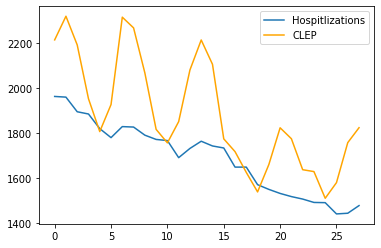

In [307]:
# Let's Plot Ensemble of Linear/Shared Exponential
LA = df_CA["hospitalizations"][0][start_day + k - 1:]
preds_LA = ensemble[0, :] 
t_LA = range(0, len(LA))
t_preds = np.array(range(0, len(preds_LA))) #+ len(t_LA) -len(t_preds) + 2
plt.plot(t_LA, LA, label="Hospitlizations")
plt.plot(t_preds, preds_LA, color="orange", label="CLEP")
plt.legend()

In [308]:
## Print the MAE
tmp_df = []
for i in range(0, len(df_CA)):
    tmp_df.append(df_CA["hospitalizations"].values[i][start_day + k - 1:])

tmp_df = np.array(tmp_df)

print("Raw MAE: %s" % mean_absolute_error(tmp_df, ensemble))
print("Log MAE: %s" % mean_absolute_error(np.log(tmp_df + 1), np.log(ensemble + 1)))



Raw MAE: 11.435629288065078
Log MAE: 0.807203095753601


In [309]:
# Computing the MAE for LA
mean_absolute_error(LA, preds_LA)

200.9507727460464

## Compute the Baseline Models

In [587]:
df_CA_county = df_county[df_county['StateName'].isin(['CA'])]

LA_data = df_CA["hospitalizations"][0]

baseline_prediction = []
moving_average = []
for i in range(start_day,54 - k + 1):
    
    
    baseline_prediction.append(UCSF_data[i-1])
    moving_average.append(np.mean(UCSF_data[i-5:i]))
    
#print(len(baseline_prediction))
plt.plot(UCSF_data[start_day+k-1:54],'r',label = "UCSF hospitalisation data")
plt.plot(baseline_prediction,'b',label = "baseline predictor")
#plt.legend()
#plt.title(str(k)+"-day ahead prediction for baseline predictor")
#print(mean_absolute_error(baseline_prediction,UCSF_data[start_day+k-1:]))

NameError: name 'UCSF_data' is not defined